# Consensus Signatures

A consensus signature can be defined as a perturbation-specific summary profile acquired by aggregating replicate level information.

### - Consensus Datasets

1. Median Aggregation
   - consensus_median (whole plate normalization)
   - consensus_median_dmso (dmso normalization).
   
   
   
   
   
2. Modified Z Score Aggregation (MODZ)
   - consensus_modz (whole plate normalization)
   - consensus_modz_dmso (dmso normalization)

The first approach weights each replicate equally.
The second approach weights replicates by average similarity to other replicates.



### The goal here is to determine the size of each MOA (Mechanism of action) for each dose based on taking the median of the correlation values between compounds of the same MOA.

In [1]:
import os
import pathlib
import pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pycytominer import feature_select
from statistics import median
sns.set_style("darkgrid")


import warnings

warnings.filterwarnings("ignore", message="Glyph 147 missing from current font.")
warnings.filterwarnings("ignore", message="Glyph 128 missing from current font.")

In [2]:
def feature_selection(dataset_link):
    """
    Perform feature selection by dropping columns with null or 
    only zeros values, and highly correlated values from the data.
    
    params: 
    dataset_link: string of github link to the consensus dataset

    Returns:
    data: returned consensus dataframe
    
    """
    data = pd.read_csv(dataset_link, compression='gzip', error_bad_lines=False)
    cols = data.columns.tolist()
    drop_cols = [x for x in cols if ((data[x].isnull().sum()) | all(y == 0.0 for y in data[x].values))]
    data.drop(drop_cols, axis = 1, inplace = True)
    data = feature_select(data, operation="correlation_threshold")
    return data

In [3]:
consensus_median_link = 'https://github.com/broadinstitute/lincs-cell-painting/blob/master/consensus/2016_04_01_a549_48hr_batch1/2016_04_01_a549_48hr_batch1_consensus_median.csv.gz?raw=true'
consensus_median_dmso_link = 'https://github.com/broadinstitute/lincs-cell-painting/blob/master/consensus/2016_04_01_a549_48hr_batch1/2016_04_01_a549_48hr_batch1_consensus_median_dmso.csv.gz?raw=true'
consensus_modz_link = 'https://github.com/broadinstitute/lincs-cell-painting/blob/master/consensus/2016_04_01_a549_48hr_batch1/2016_04_01_a549_48hr_batch1_consensus_modz.csv.gz?raw=true'
consensus_modz_dmso_link = 'https://github.com/broadinstitute/lincs-cell-painting/blob/master/consensus/2016_04_01_a549_48hr_batch1/2016_04_01_a549_48hr_batch1_consensus_modz_dmso.csv.gz?raw=true'

### - In this notebook, only the results of consensus_modz_dmso are shown, but the results are very similar to other consensus datasets

In [4]:
data = feature_selection(consensus_modz_dmso_link)

In [5]:
data.shape

(10752, 610)

Text(0.5, 0.98, 'Correlation between Phenotypic measurements columns (features)')

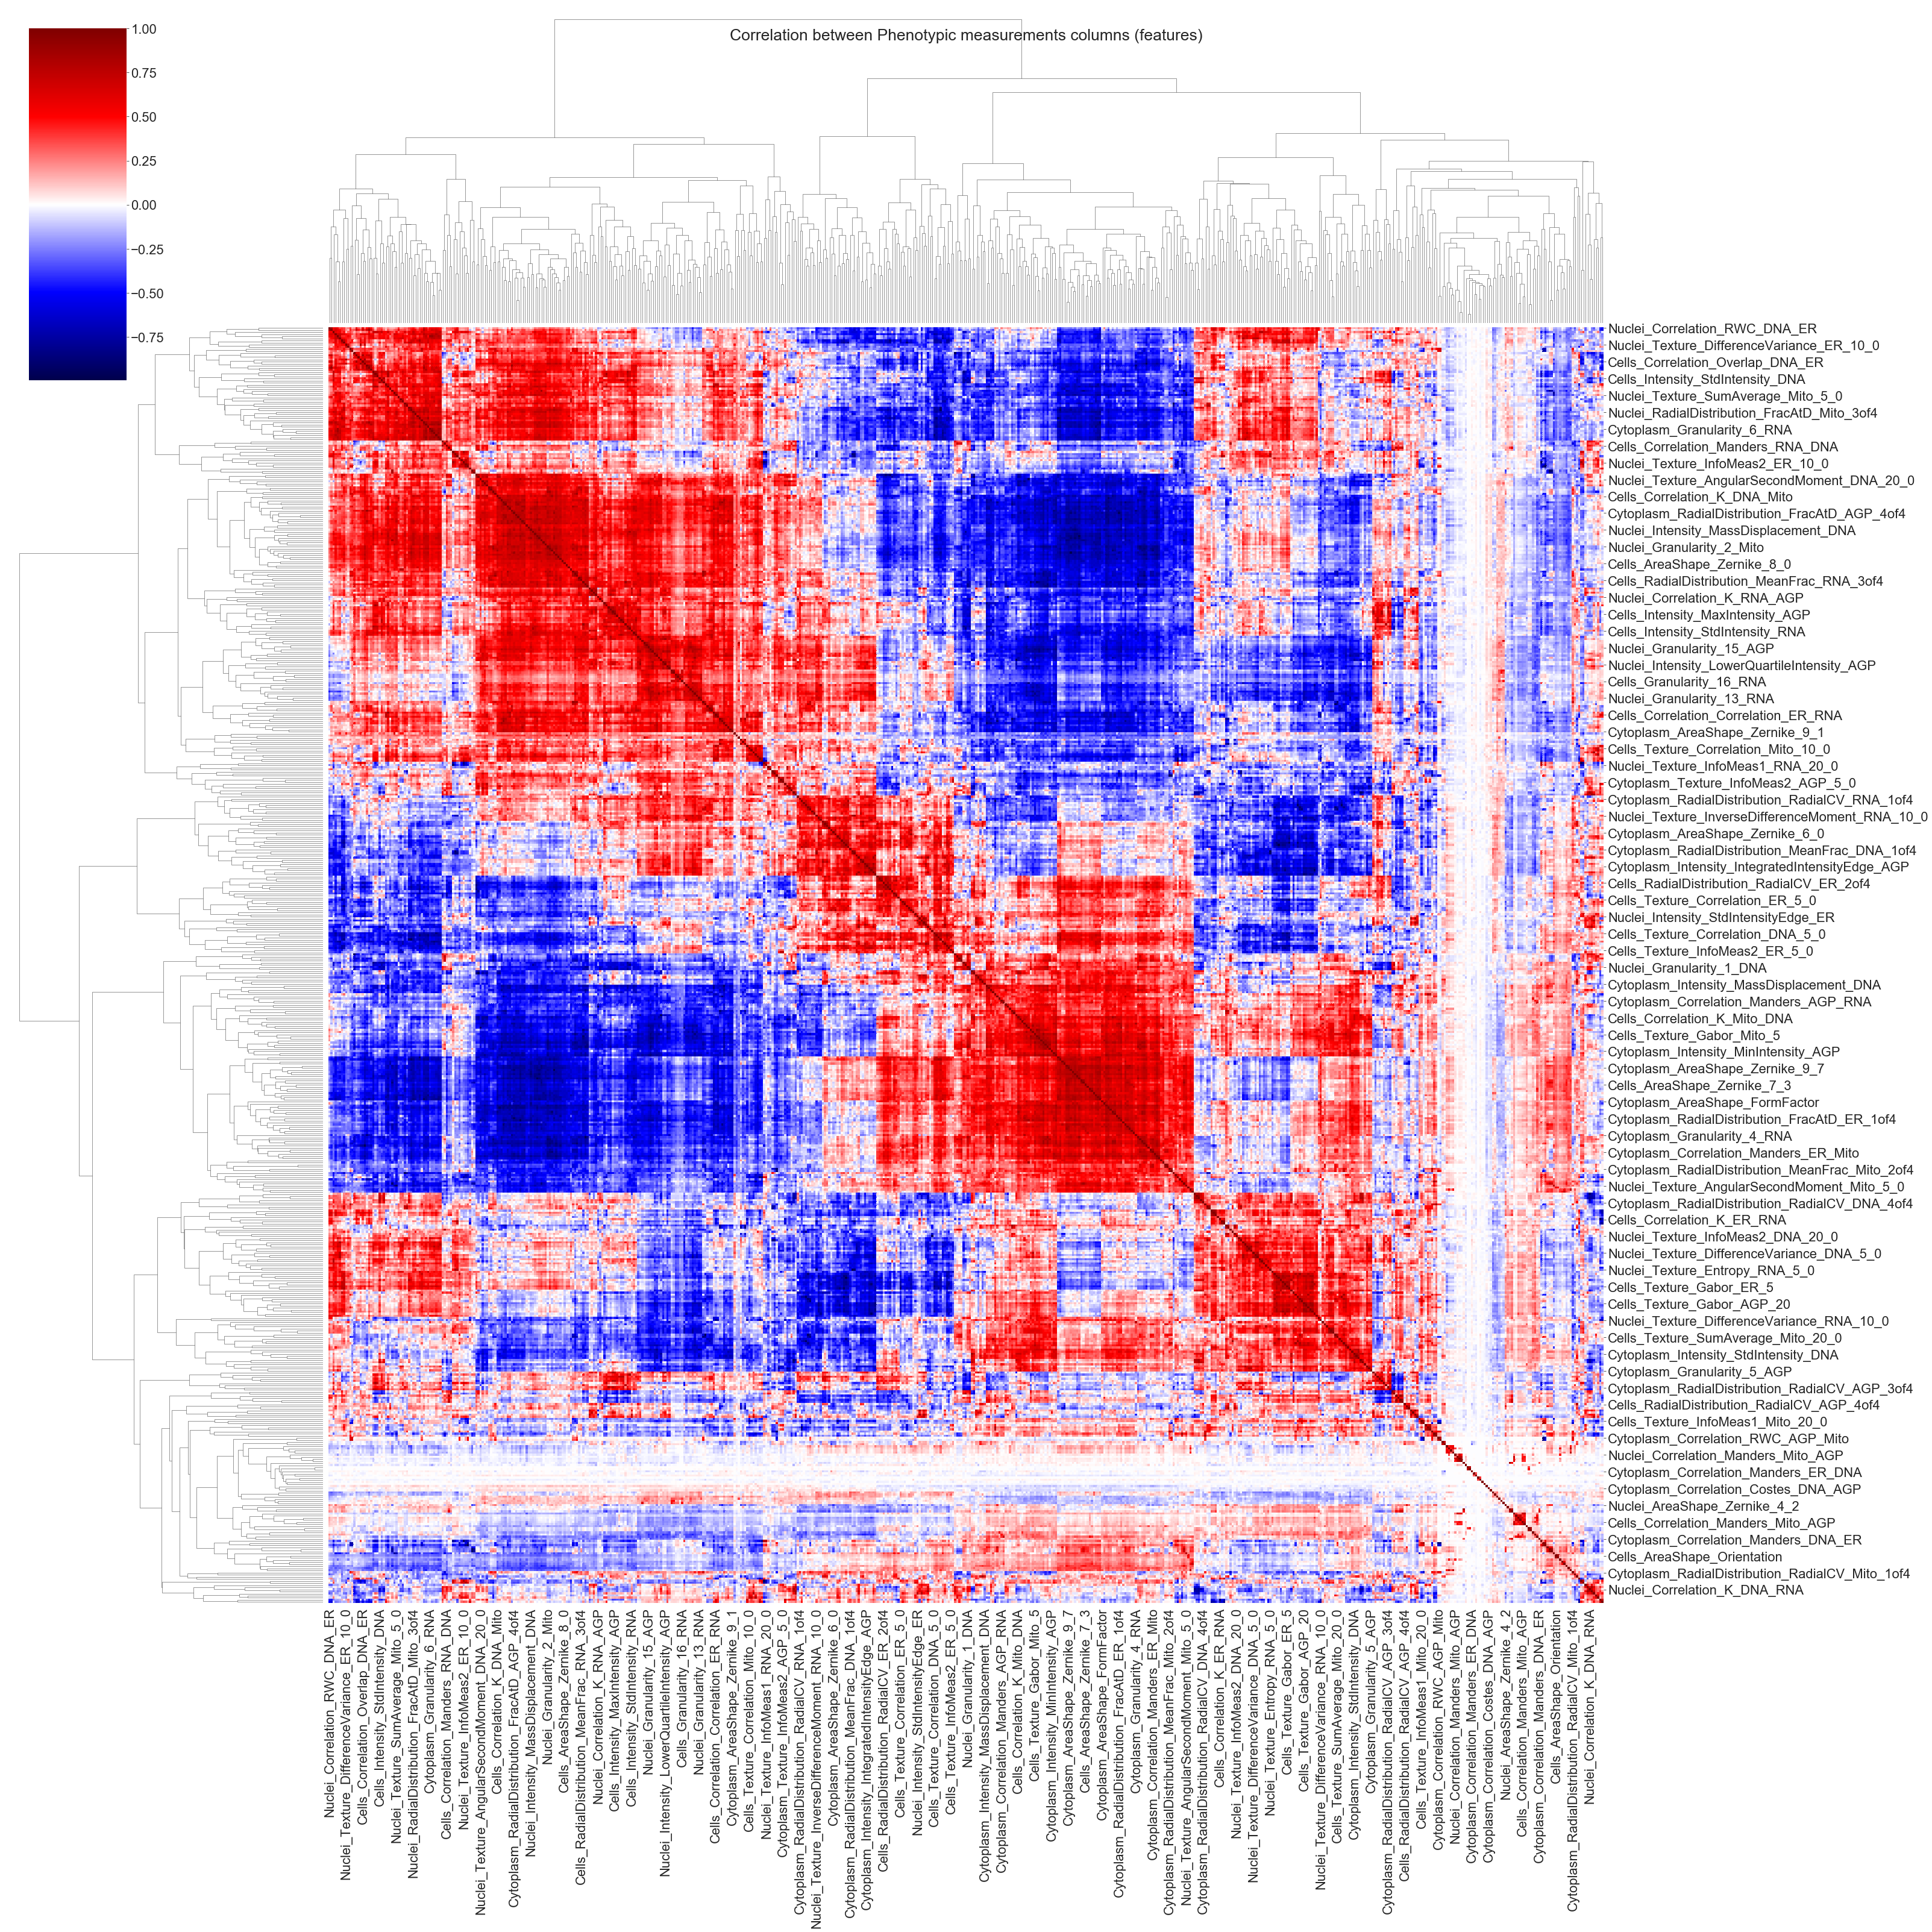

In [6]:
##heatmap -- showing correlation btw features
plt.rcParams.update({'font.size': 22})
sns.clustermap(data.corr(), cmap='seismic', figsize=(45, 45)).fig.suptitle('Correlation between Phenotypic measurements columns (features)')  ##col_cluster=False, 

### Mechanism of actions (MOAs)

In [7]:
def merge_moa_data(dataset_link, data):
    
    """
    Merge (mechanism of action) moa dataframe with the consensus dataframe,
    based on distinct broad samples.
    
    params: 
    dataset_link: string of moa_dataset github link
    data: consensus dataframe

    Returns:
    data_moa: merged consensus and moa dataframe with moas
    no_moa_data: merged consensus and moa dataframe without moas
    
    """
    moa_df = pd.read_csv(dataset_link, sep="\t")
    moa_df.drop(['alternative_moa', 'alternative_target'], axis = 1, inplace = True)
    ##append DMSO as row to the moa_df
    dmso = ['DMSO', 'BRD-DMSO', 'DMSO compound', 'DMSO Key', 'DMSO', \
            'DMSO-No Target', 'broad_id_20201014', 'DMSO-No Phase']
    moa_df.loc[len(moa_df)] = dmso
    moa_df.rename(columns={"broad_sample": "Metadata_broad_sample"}, inplace = True)
    data_moa = data.merge(moa_df, on='Metadata_broad_sample', how = 'outer')
    no_moa_data = data_moa[data_moa['moa'].isnull()].copy().reset_index(drop = True)
    data_moa.drop(data_moa['Metadata_broad_sample'][data_moa['moa'].isnull()].index, inplace = True)
    data_moa.reset_index(drop= True, inplace = True)
    
    return data_moa, no_moa_data

In [8]:
moa_dataset = "https://github.com/broadinstitute/lincs-cell-painting/blob/master/metadata/moa/repurposing_info_external_moa_map_resolved.tsv?raw=true"
df_moa, df_no_moa = merge_moa_data(moa_dataset, data)

In [9]:
df_moa.shape

(10440, 617)

In [10]:
df_no_moa.shape

(312, 617)

In [11]:
##list of "Broad samples" WITHOUT Mechanism of Actions --MOA
df_no_moa['Metadata_broad_sample'].unique().tolist()

['BRD-K03842655-001-02-1',
 'BRD-K25837718-001-03-8',
 'BRD-K16508793-001-05-9',
 'BRD-K21547160-001-01-4',
 'BRD-A37288617-003-02-2',
 'BRD-A44448661-001-04-8',
 'BRD-A84045418-001-03-1',
 'BRD-K01192156-001-02-7',
 'BRD-K41438959-001-01-7',
 'BRD-K51033547-003-02-6',
 'BRD-K52080565-001-09-2',
 'BRD-K60623809-001-02-0',
 'BRD-K73395020-001-02-3',
 'BRD-A20131130-001-01-7',
 'BRD-K87278688-001-01-0',
 'BRD-M98279124-300-01-1',
 'BRD-K30563334-001-02-9',
 'BRD-A11990600-001-03-4',
 'BRD-K03816923-001-05-4',
 'BRD-A67373739-001-02-2',
 'BRD-K38183498-001-02-0',
 'BRD-K42417338-045-01-9',
 'BRD-M39350793-334-01-1',
 'BRD-A55393291-001-09-9',
 'BRD-A57382968-001-29-0',
 'BRD-K58626373-003-07-8',
 'BRD-A43331270-001-01-6',
 'BRD-A58280226-312-01-3',
 'BRD-A69951442-001-01-3',
 'BRD-A77216878-001-01-4',
 'BRD-K23875128-001-04-2',
 'BRD-K36324071-363-01-3',
 'BRD-K41895714-001-01-4',
 'BRD-K55013654-003-02-3',
 'BRD-K04887706-375-01-4',
 'BRD-K44876623-001-03-7',
 'BRD-A84174393-236-07-1',
 

### - Get Correlation (using Spearman coefficient)  between compounds for all DOSES (1 - 7).

### - Then, Get the correlation values btw compounds of each particular MOA, and calculate the median from the correlation values and assign it as the "SIZE" of the MOA.

## Recoding Dose Information

The Drug Repurposing Hub collected data on 6 to 7 dose points per compound.
In general, most doses are very near the following 7 dose points (mmoles per liter):

> [0.04, 0.12, 0.37, 1.11, 3.33, 10, 20]

Therefore, to make it easier to filter by dose when comparing compounds, we first align the doses collected in the dataset to their nearest dose point above.
We then recode the dose points into ascending numerical levels and add a new metadata annotation `dose_recode` to the consensus signatures.

| Dose | Dose Recode |
| :--: | :---------: |
| 0 (DMSO) | 0 |
| ~0.04 | 1 |
| ~0.12 | 2 |
| ~0.37 | 3 |
| ~1.11 | 4 |
| ~3.33 | 5 |
| ~10 | 6 |
| ~20 | 7 |

In [12]:
def get_median_moa_size(moa_list, df_dose, df_dose_corr):
    
    """
    Get the correlation values between compounds of each MOA, 
    then calculate the median of these correlation values 
    and assign it as the "SIZE" of the MOA.
    
    params: 
    moa_list: list of distinct moas for a particular dose
    df_dose: merged consensus and moa dataframe of a partcular dose
    df_dose_corr: merged consensus and moa dataframe of compound correlations of a particular dose

    Returns:
    moa_size: Dict with moa as the keys, and their size as the values
    moa_cpds: Dict with moa as the keys, and the list of moa for each moa as the values
    
    """
    
    moa_cpds = {}
    moa_size = {}
    for moa in moa_list:
        cpds = df_dose['pert_iname'][df_dose['moa'] == moa].unique().tolist()
        moa_cpds[moa] = cpds
        ##taking correlation btw cpds for each MOA
        val_corr = []
        for x in range(len(cpds)):
            for y in range(x+1, len(cpds)):
                corr_val = abs(df_dose_corr.loc[cpds[y], cpds[x]])
                val_corr.append(corr_val)
        
        ##take median value of the correlation values, 
        ##if there is only one cpd --assign median == 1 for the MOA
        if val_corr:
            median_val = median(val_corr)
        else:
            median_val = 1
        moa_size[moa] = median_val
        
    return moa_size, moa_cpds

In [13]:
def check_moa(moa_size, moa_cpds, df_moa):
    """
    Check if all distinct moas in the moa_consensus dataframe (df_moa) 
    are in moa_size & moa_cpd, if not add them as keys and give them
    a null value as the size for moa_size, 
    and add list of cpds as values for moa_cpds.
    
    params: 
    moa_size: Dict with moa as the keys, and their size as the values
    moa_cpds: Dict with moa as the keys, and the list of moa for each moa as the values
    data_moa: merged consensus and moa df with moas

    Returns:
    moa_size: Dict with moa as the keys, and their size as the values
    moa_cpds: Dict with moa as the keys, and the list of moa for each moa as the values
    
    """
    moa_list = df_moa['moa'].unique().tolist()
    moa_keys = moa_size.keys()
    for moa in moa_list:
        if moa not in moa_keys:
            moa_size[moa] = np.nan
            cpds = df_moa['pert_iname'][df_moa['moa'] == moa].unique().tolist()
            moa_cpds[moa] = cpds
    return moa_size, moa_cpds

In [14]:
def get_moasize_df(df_moa):
    
    """
    Generate a dataframe of distinct moas with their sizes and
    corresponding list of compounds for different doses.
    
    params: 
    df_moa: merged consensus and moa dataframe

    Returns:
    df_moa_size: dataframe of distinct moas with their corresponding sizes 
    and list of compounds for all doses.
    
    """
    dose_list = list(set(df_moa['Metadata_dose_recode'].unique().tolist()))[1:]
    
    for dose in dose_list:
        df_dose = df_moa[df_moa['Metadata_dose_recode'] == dose].copy()
        df_cpd_agg = df_dose.groupby(['pert_iname']).agg(['mean'])
        #droplevel
        df_cpd_agg.columns  = df_cpd_agg.columns.droplevel(1)
        df_cpd_agg.rename_axis(None, axis=0, inplace = True)
        df_cpd_agg.drop(['Metadata_mmoles_per_liter', 'Metadata_dose_recode'], axis = 1, inplace = True)
        df_dose_corr = df_cpd_agg.T.corr(method = 'spearman')
        dose_moa_list = df_dose['moa'].unique().tolist()
        #get the median of the corr values of the cpds for each MOA
        dose_moa_size, dose_moa_cpds = get_median_moa_size(dose_moa_list, df_dose, df_dose_corr)
        #check if all moa in the df_moa is present in the dose_moa
        dose_moa_size, dose_moa_cpds = check_moa(dose_moa_size, dose_moa_cpds, df_moa)
        sorted_moa_size = {key:value for key, value in sorted(dose_moa_size.items(), key=lambda item: item[0])}
        sorted_dose_cpds = {key:value for key, value in sorted(dose_moa_cpds.items(), key=lambda item: item[0])}
        if dose == 1:
            df_moa_size = pd.DataFrame.from_dict(sorted_moa_size, orient='index', columns = ['dose_1'])
        else:
            df_moa_size['dose_' + str(dose)] = sorted_moa_size.values()
        df_moa_size['moa_cpds_dose_' + str(dose)] = list(sorted_dose_cpds.values())
            
    return df_moa_size

In [15]:
data_moa_size = get_moasize_df(df_moa)

In [16]:
data_moa_size.sample(10)

dose_1  \
KIT inhibitor|VEGFR inhibitor                       1.000000   
CDK inhibitor|growth factor receptor inhibitor      1.000000   
cytomegalovirus inhibitor|protein kinase inhibitor  1.000000   
MEK inhibitor                                       0.231292   
glycosyl transferase inhibitor                      1.000000   
estrogen receptor agonist                           0.231375   
microtubule stabilizing agent                       1.000000   
apoptosis stimulant                                 1.000000   
PLK inhibitor                                       0.827228   
adenosine reuptake inhibitor                        1.000000   

                                                                                      moa_cpds_dose_1  \
KIT inhibitor|VEGFR inhibitor                                                             [cediranib]   
CDK inhibitor|growth factor receptor inhibitor                                           [PHA-848125]   
cytomegalovirus inhibitor|protein kinase inhibitor                                        [maribavir]   
MEK inhibitor                                       [AS-703026, TAK-733, PD-184352, cobimetinib, A...   
glycosyl transferase inhibitor                                                            [miglustat]   
estrogen receptor agonist                           [estriol, estradiol, mestranol, equol, MF-101,...   
microtubule stabilizing agent                                                           [ixabepilone]   
apoptosis stimulant                                                                       [tasisulam]   
PLK inhibitor                                       [BI-2536, NMS-1286937, volasertib, HMN-214, GS...   
adenosine reuptake inhibitor                                                                [dilazep]   

                                                      dose_2  \
KIT inhibitor|VEGFR inhibitor                       1.000000   
CDK inhibitor|growth factor receptor inhibitor      1.000000   
cytomegalovirus inhibitor|protein kinase inhibitor  1.000000   
MEK inhibitor                                       0.401511   
glycosyl transferase inhibitor                      1.000000   
estrogen receptor agonist                           0.316305   
microtubule stabilizing agent                       1.000000   
apoptosis stimulant                                 1.000000   
PLK inhibitor                                       0.773952   
adenosine reuptake inhibitor                        1.000000   

                                                                                      moa_cpds_dose_2  \
KIT inhibitor|VEGFR inhibitor                                                             [cediranib]   
CDK inhibitor|growth factor receptor inhibitor                                           [PHA-848125]   
cytomegalovirus inhibitor|protein kinase inhibitor                                        [maribavir]   
MEK inhibitor                                       [AS-703026, TAK-733, PD-184352, cobimetinib, A...   
glycosyl transferase inhibitor                                                            [miglustat]   
estrogen receptor agonist                           [estriol, estradiol, mestranol, equol, MF-101,...   
microtubule stabilizing agent                                                           [ixabepilone]   
apoptosis stimulant                                                                       [tasisulam]   
PLK inhibitor                                       [BI-2536, NMS-1286937, volasertib, HMN-214, GS...   
adenosine reuptake inhibitor                                                                [dilazep]   

                                                      dose_3  \
KIT inhibitor|VEGFR inhibitor                       1.000000   
CDK inhibitor|growth factor receptor inhibitor      1.000000   
cytomegalovirus inhibitor|protein kinase inhibitor  1.000000   
MEK inhibitor                                       0.606595   
glycosyl tra

### - Exclude MOAs with size 1

#### The reason why we are excluding MOAs with size/value == 1, is because they have only ONE compound and as a result the medain correlation value will be just 1, and there will not be differences in values btw different doses.

In [17]:
def exclude_moa(df_moa_size):
    """
    Exclude MOAs with size 1.
    
    params: 
    df_moa_size: dataframe of distinct moas with their corresponding sizes 
    and list of compounds for all doses.

    Returns:
    df_moa_medians: dataframe of distinct moas with NO median values/sizes of 1 
    and their corresponding list of compounds for all doses.
    
    """
    moa_with_med_index = []
    for moa in df_moa_size.index.tolist():
        moa_values = df_moa_size.loc[moa]
        if all(y != 1.0 for y in moa_values):
            moa_with_med_index.append(moa)
    df_moa_medians = df_moa_size.loc[moa_with_med_index]
    return df_moa_medians

In [18]:
data_moa_medians = exclude_moa(data_moa_size)

In [19]:
##232 MOAs with median values corresponding to correlation btw their cpds
data_moa_medians.shape

(232, 14)

In [20]:
def seperate_cpds_values(df_moa_medians):
    """
    Seperate the list of compunds columns from the values columns in
    moa_median_dataframe
    
    params: 
    df_moa_medians: dataframe of distinct moas with NO median values/sizes of 1 
    and their corresponding list of compounds for all doses.

    Returns:
    df_moa_cpds: dataframe of distinct moas with only their corresponding 
    list of compounds for all doses.
    
    df_moa_values: dataframe of distinct moas with only their sizes for all doses.
    """
    dose_cols = [col for col in df_moa_medians.columns.tolist() 
                 if (col.startswith("dose_"))]
    df_moa_cpds = df_moa_medians.drop(dose_cols, axis = 1)
    df_moa_values = df_moa_medians.loc[:, dose_cols].copy()
    
    return df_moa_cpds, df_moa_values

In [21]:
data_moa_cpds, data_moa_values = seperate_cpds_values(data_moa_medians)

In [22]:
data_moa_cpds.head()

moa_cpds_dose_1  \
5 alpha reductase inhibitor                     [dutasteride, finasteride, acexamic-acid]   
ACAT inhibitor                                                [avasimibe, KD-023, CI-976]   
AKT inhibitor                           [10-DEBC, GSK2110183, GDC-0068, MK-2206, honok...   
ALK tyrosine kinase receptor inhibitor        [alectinib, AP26113, CEP-37440, crizotinib]   
ATP channel blocker                             [tolazamide, tolbutamide, chlorpropamide]   

                                                                          moa_cpds_dose_2  \
5 alpha reductase inhibitor                     [dutasteride, finasteride, acexamic-acid]   
ACAT inhibitor                                                [avasimibe, KD-023, CI-976]   
AKT inhibitor                           [10-DEBC, GSK2110183, GDC-0068, MK-2206, honok...   
ALK tyrosine kinase receptor inhibitor        [alectinib, AP26113, CEP-37440, crizotinib]   
ATP channel blocker                             [tolazamide, tolbutamide, chlorpropamide]   

                                                                          moa_cpds_dose_3  \
5 alpha reductase inhibitor                     [dutasteride, finasteride, acexamic-acid]   
ACAT inhibitor                                                [avasimibe, KD-023, CI-976]   
AKT inhibitor                           [10-DEBC, GSK2110183, GDC-0068, MK-2206, honok...   
ALK tyrosine kinase receptor inhibitor        [alectinib, AP26113, CEP-37440, crizotinib]   
ATP channel blocker                             [tolazamide, tolbutamide, chlorpropamide]   

                                                                          moa_cpds_dose_4  \
5 alpha reductase inhibitor                     [dutasteride, finasteride, acexamic-acid]   
ACAT inhibitor                                                [avasimibe, KD-023, CI-976]   
AKT inhibitor                           [10-DEBC, GSK2110183, GDC-0068, MK-2206, honok...   
ALK tyrosine kinase receptor inhibitor        [alectinib, AP26113, CEP-37440, crizotinib]   
ATP channel blocker                             [tolazamide, tolbutamide, chlorpropamide]   

                                                                          moa_cpds_dose_5  \
5 alpha reductase inhibitor                     [dutasteride, finasteride, acexamic-acid]   
ACAT inhibitor                                                [avasimibe, KD-023, CI-976]   
AKT inhibitor                           [10-DEBC, GSK2110183, GDC-0068, MK-2206, honok...   
ALK tyrosine kinase receptor inhibitor        [alectinib, AP26113, CEP-37440, crizotinib]   
ATP channel blocker                             [tolazamide, tolbutamide, chlorpropamide]   

                                                                          moa_cpds_dose_6  \
5 alpha reductase inhibitor                     [dutasteride, finasteride, acexamic-acid]   
ACAT inhibitor                                                [avasimibe, KD-023, CI-976]   
AKT inhibitor                           [10-DEBC, GSK2110183, GDC-0068, MK-2206, honok...   
ALK tyrosine kinase receptor inhibitor        [alectinib, AP26113, CEP-37440, crizotinib]   
ATP channel blocker                             [tolazamide, tolbutamide, chlorpropamide]   

                                                                          moa_cpds_dose_7  
5 alpha reductase inhibitor                     [dutasteride, finasteride, acexamic-acid]  
ACAT inhibitor                                                [avasimibe, KD-023, CI-976]  
AKT inhibitor                           [10-DEBC, GSK2110183, GDC-0068, MK-2206, honok...  
ALK tyrosine kinase receptor inhibitor        [alectinib, AP26113, CEP-37440, crizotinib]  
ATP channel blocker                             [tolazamide, tolbutamide, chlorpropamide]

### - Check if the MOAs have the same compounds in all the Doses

In [23]:
def check_moas_cpds_doses(df_moa_cpds):
    """
    check if moas have the same compounds in all doses,
    and return the moas that don't have the same numbers of compounds.
    
    params: 
    df_moa_cpds: dataframe of distinct moas with only their corresponding 
    list of compounds for all doses.

    Returns:
    df_moa_not_equals_cpds: dataframe of moas that don't have the same numbers of 
    compounds in all doses.
    
    """
    moas_with_no_equal_cpds = [moa for moa in df_moa_cpds.index 
                               for num in range(len(df_moa_cpds.columns) - 1) 
                               if not ((df_moa_cpds.loc[moa, df_moa_cpds.columns[num]]) 
                                       == (df_moa_cpds.loc[moa, df_moa_cpds.columns[num+1]]))]
    df_moa_not_equals_cpds = df_moa_cpds.loc[set(moas_with_no_equal_cpds)]
    
    return df_moa_not_equals_cpds

In [24]:
data_moa_not_equals_cpds = check_moas_cpds_doses(data_moa_cpds) ##MOAs with not the same cpds in all doses

### - MOAS that do not have the same number of compounds in all Doses

In [25]:
for moa in data_moa_not_equals_cpds.index:
    print(moa)
    for idx, cols in enumerate(data_moa_not_equals_cpds.columns):
        print('Dose ' + str(idx+1) +':', data_moa_cpds.loc[moa, cols])
    print('\n')

NFkB pathway inhibitor
Dose 1: ['bindarit', 'erythromycin', 'sasapyrine', 'cepharanthine', 'MD-920']
Dose 2: ['bindarit', 'erythromycin', 'sasapyrine', 'cepharanthine', 'MD-920']
Dose 3: ['bindarit', 'erythromycin', 'sasapyrine', 'cepharanthine', 'MD-920']
Dose 4: ['bindarit', 'erythromycin', 'sasapyrine', 'cepharanthine', 'MD-920']
Dose 5: ['bindarit', 'erythromycin', 'sasapyrine', 'cepharanthine', 'MD-920']
Dose 6: ['bindarit', 'erythromycin', 'sasapyrine', 'cepharanthine']
Dose 7: ['bindarit', 'erythromycin', 'sasapyrine', 'cepharanthine', 'MD-920']


PKC inhibitor
Dose 1: ['sotrastaurin', 'GF109203X', 'ethylenediaminetetraacetic-acid', 'enzastaurin', 'dequalinium', 'safingol']
Dose 2: ['sotrastaurin', 'GF109203X', 'ethylenediaminetetraacetic-acid', 'enzastaurin', 'dequalinium', 'safingol']
Dose 3: ['sotrastaurin', 'GF109203X', 'ethylenediaminetetraacetic-acid', 'enzastaurin', 'dequalinium', 'safingol']
Dose 4: ['sotrastaurin', 'GF109203X', 'ethylenediaminetetraacetic-acid', 'enzast

### - MOAS with their sizes for all doses

In [26]:
data_moa_values.drop(['dose_7'], axis = 1, inplace = True) ##drop dose_7 because it has values for only 2 MOAS
data_moa_values.drop(['DMSO'], axis = 0, inplace = True) ##drop DMSO, not found in all doses except dose_0

In [27]:
data_moa_values.head(20)

dose_1    dose_2    dose_3  \
5 alpha reductase inhibitor               0.591606  0.482898  0.368509   
ACAT inhibitor                            0.162153  0.166156  0.220333   
AKT inhibitor                             0.326814  0.198159  0.198940   
ALK tyrosine kinase receptor inhibitor    0.265592  0.281750  0.197908   
ATP channel blocker                       0.186811  0.326806  0.232535   
ATPase inhibitor                          0.378304  0.283141  0.135800   
Aurora kinase inhibitor                   0.261896  0.586346  0.792402   
BCL inhibitor                             0.142732  0.411394  0.230504   
Bcr-Abl kinase inhibitor                  0.533467  0.457616  0.031234   
Bruton's tyrosine kinase (BTK) inhibitor  0.059459  0.192865  0.090954   
CC chemokine receptor antagonist          0.299061  0.288563  0.329497   
CCK receptor antagonist                   0.270752  0.345263  0.311605   
CDK inhibitor                             0.350367  0.562546  0.422264   
CFTR channel agonist                      0.118493  0.268940  0.167356   
DNA alkylating agent                      0.165501  0.265798  0.209192   
DNA directed DNA polymerase inhibitor     0.137356  0.574777  0.574301   
DNA inhibitor                             0.292772  0.171075  0.218657   
DNA methyltransferase inhibitor           0.323008  0.234121  0.381625   
DNA polymerase inhibitor                  0.303551  0.181392  0.372820   
DNA synthesis inhibitor                   0.104163  0.189373  0.206630   

                                            dose_4    dose_5    dose_6  
5 alpha reductase inhibitor               0.089636  0.202425  0.179018  
ACAT inhibitor                            0.301147  0.237705  0.249738  
AKT inhibitor                             0.368539  0.274403  0.576004  
ALK tyrosine kinase receptor inhibitor    0.150485  0.478105  0.478442  
ATP channel blocker                       0.336200  0.299052  0.374784  
ATPase inhibitor                          0.193293  0.104981  0.029639  
Aurora kinase inhibitor                   0.876683  0.899713  0.804162  
BCL inhibitor                             0.425003  0.438570  0.474600  
Bcr-Abl kinase inhibitor                  0.017619  0.207209  0.337485  
Bruton's tyrosine kinase (BTK) inhibitor  0.295775  0.455931  0.458942  
CC chemokine receptor antagonist          0.277335  0.311680  0.349234  
CCK receptor antagonist                   0.171653  0.150116  0.307275  
CDK inhibitor                             0.546196  0.648535  0.646018  
CFTR channel agonist                      0.248701  0.481064  0.126005  
DNA alkylating agent                      0.428252  0.488265  0.610304  
DNA directed DNA polymerase inhibitor     0.597617  0.360119  0.269974  
DNA inhibitor                             0.293267  0.349404  0.490751  
DNA methyltransferase inhibitor           0.454168  0.394498  0.430241  
DNA polymerase inhibitor                  0.307906  0.379776  0.540564  
DNA synthesis inhibitor                   0.201313  0.224971  0.354656

In [28]:
def save_to_csv(df, file_name):
    """saves moa sizes dataframe to csv"""
    
    if not os.path.exists('moa_sizes_consensus_datasets'):
        os.mkdir('moa_sizes_consensus_datasets')
    
    df.to_csv(os.path.join('moa_sizes_consensus_datasets', file_name))

In [29]:
save_to_csv(data_moa_values, 'modz_dmso_moa_sizes')

In [30]:
def plot_save_heatmap(df_moa_values, file_name):
    """Generate and save heatmap plot for the moa sizes dataframe based on different doses"""
    
    if not os.path.exists('consensus_imgs'):
        os.mkdir('consensus_imgs')
        
    plt.rcParams.update({'font.size': 22})
    plt.figure(figsize=(45,45)) 
    plt.title("Variation in MOA sizes across different doses")
    sns.heatmap(df_moa_values, cmap='Reds')
    plt.savefig(os.path.join('consensus_imgs', file_name))
    plt.show()

### - Split the dataframe into 3 parts for easier visualization

### - Plots - variation in MOA sizes across different doses

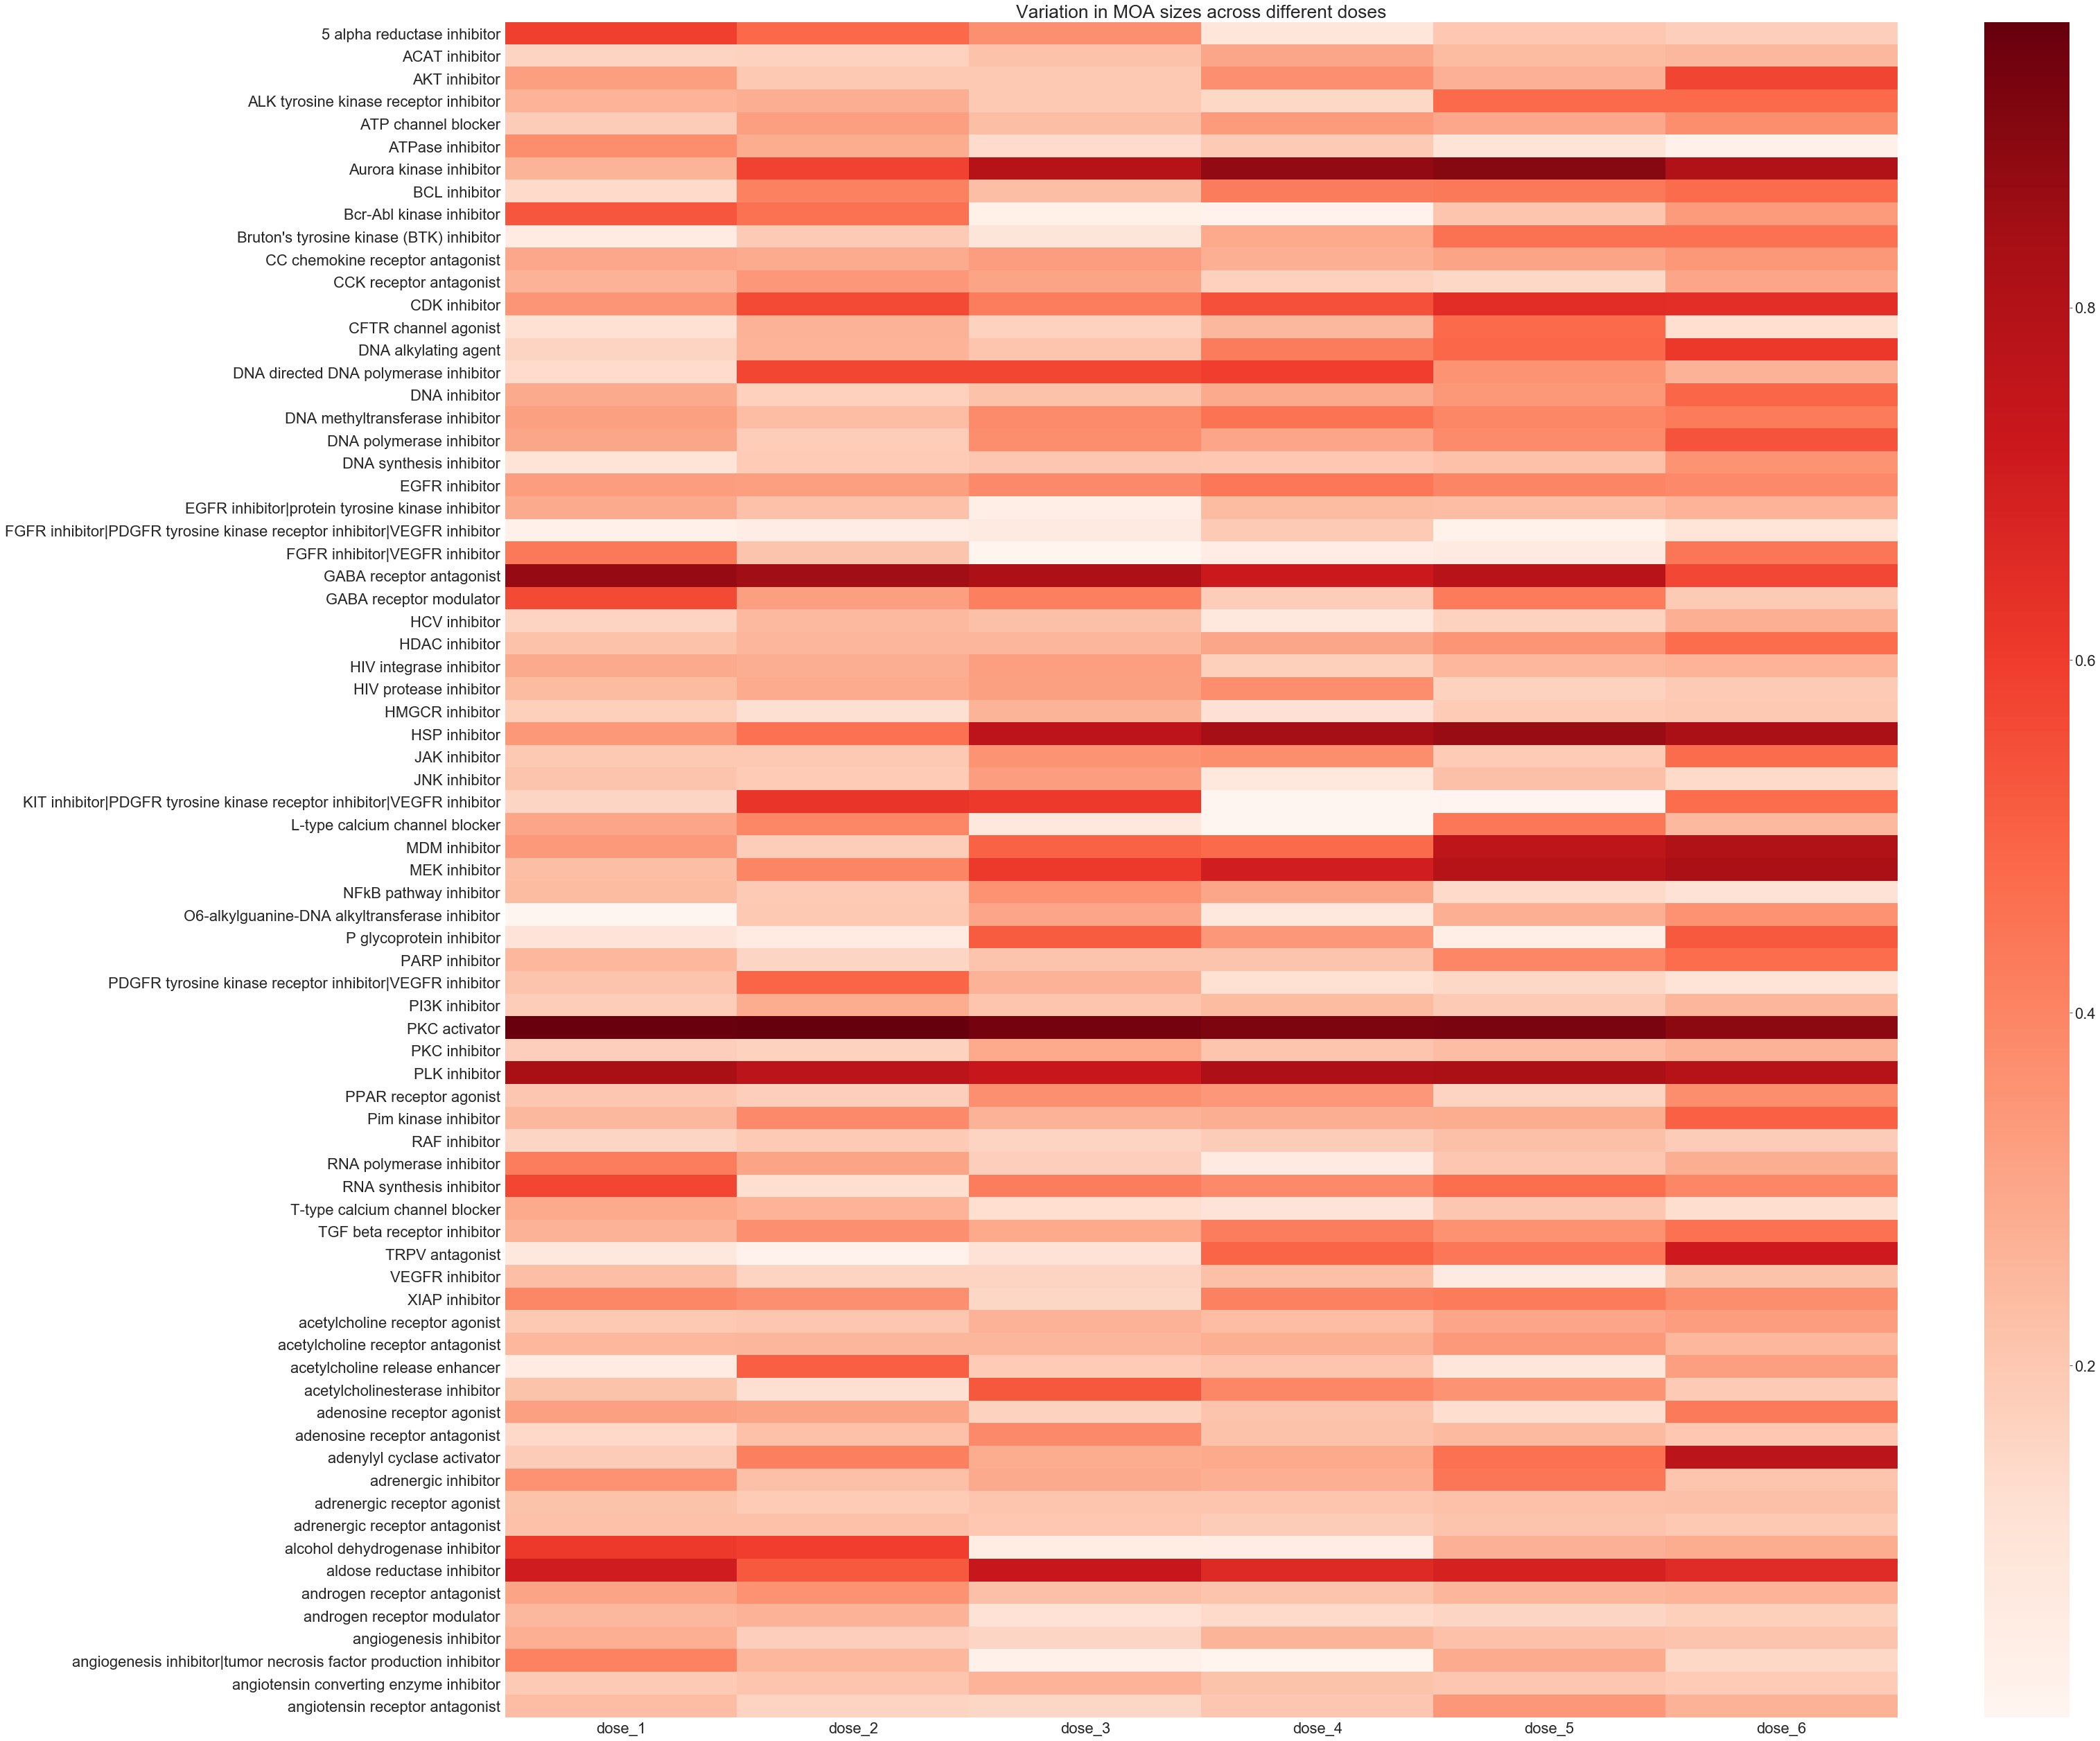

In [31]:
plot_save_heatmap(data_moa_values.iloc[:75, :], 'modz_dmso_heatmap_1.png')

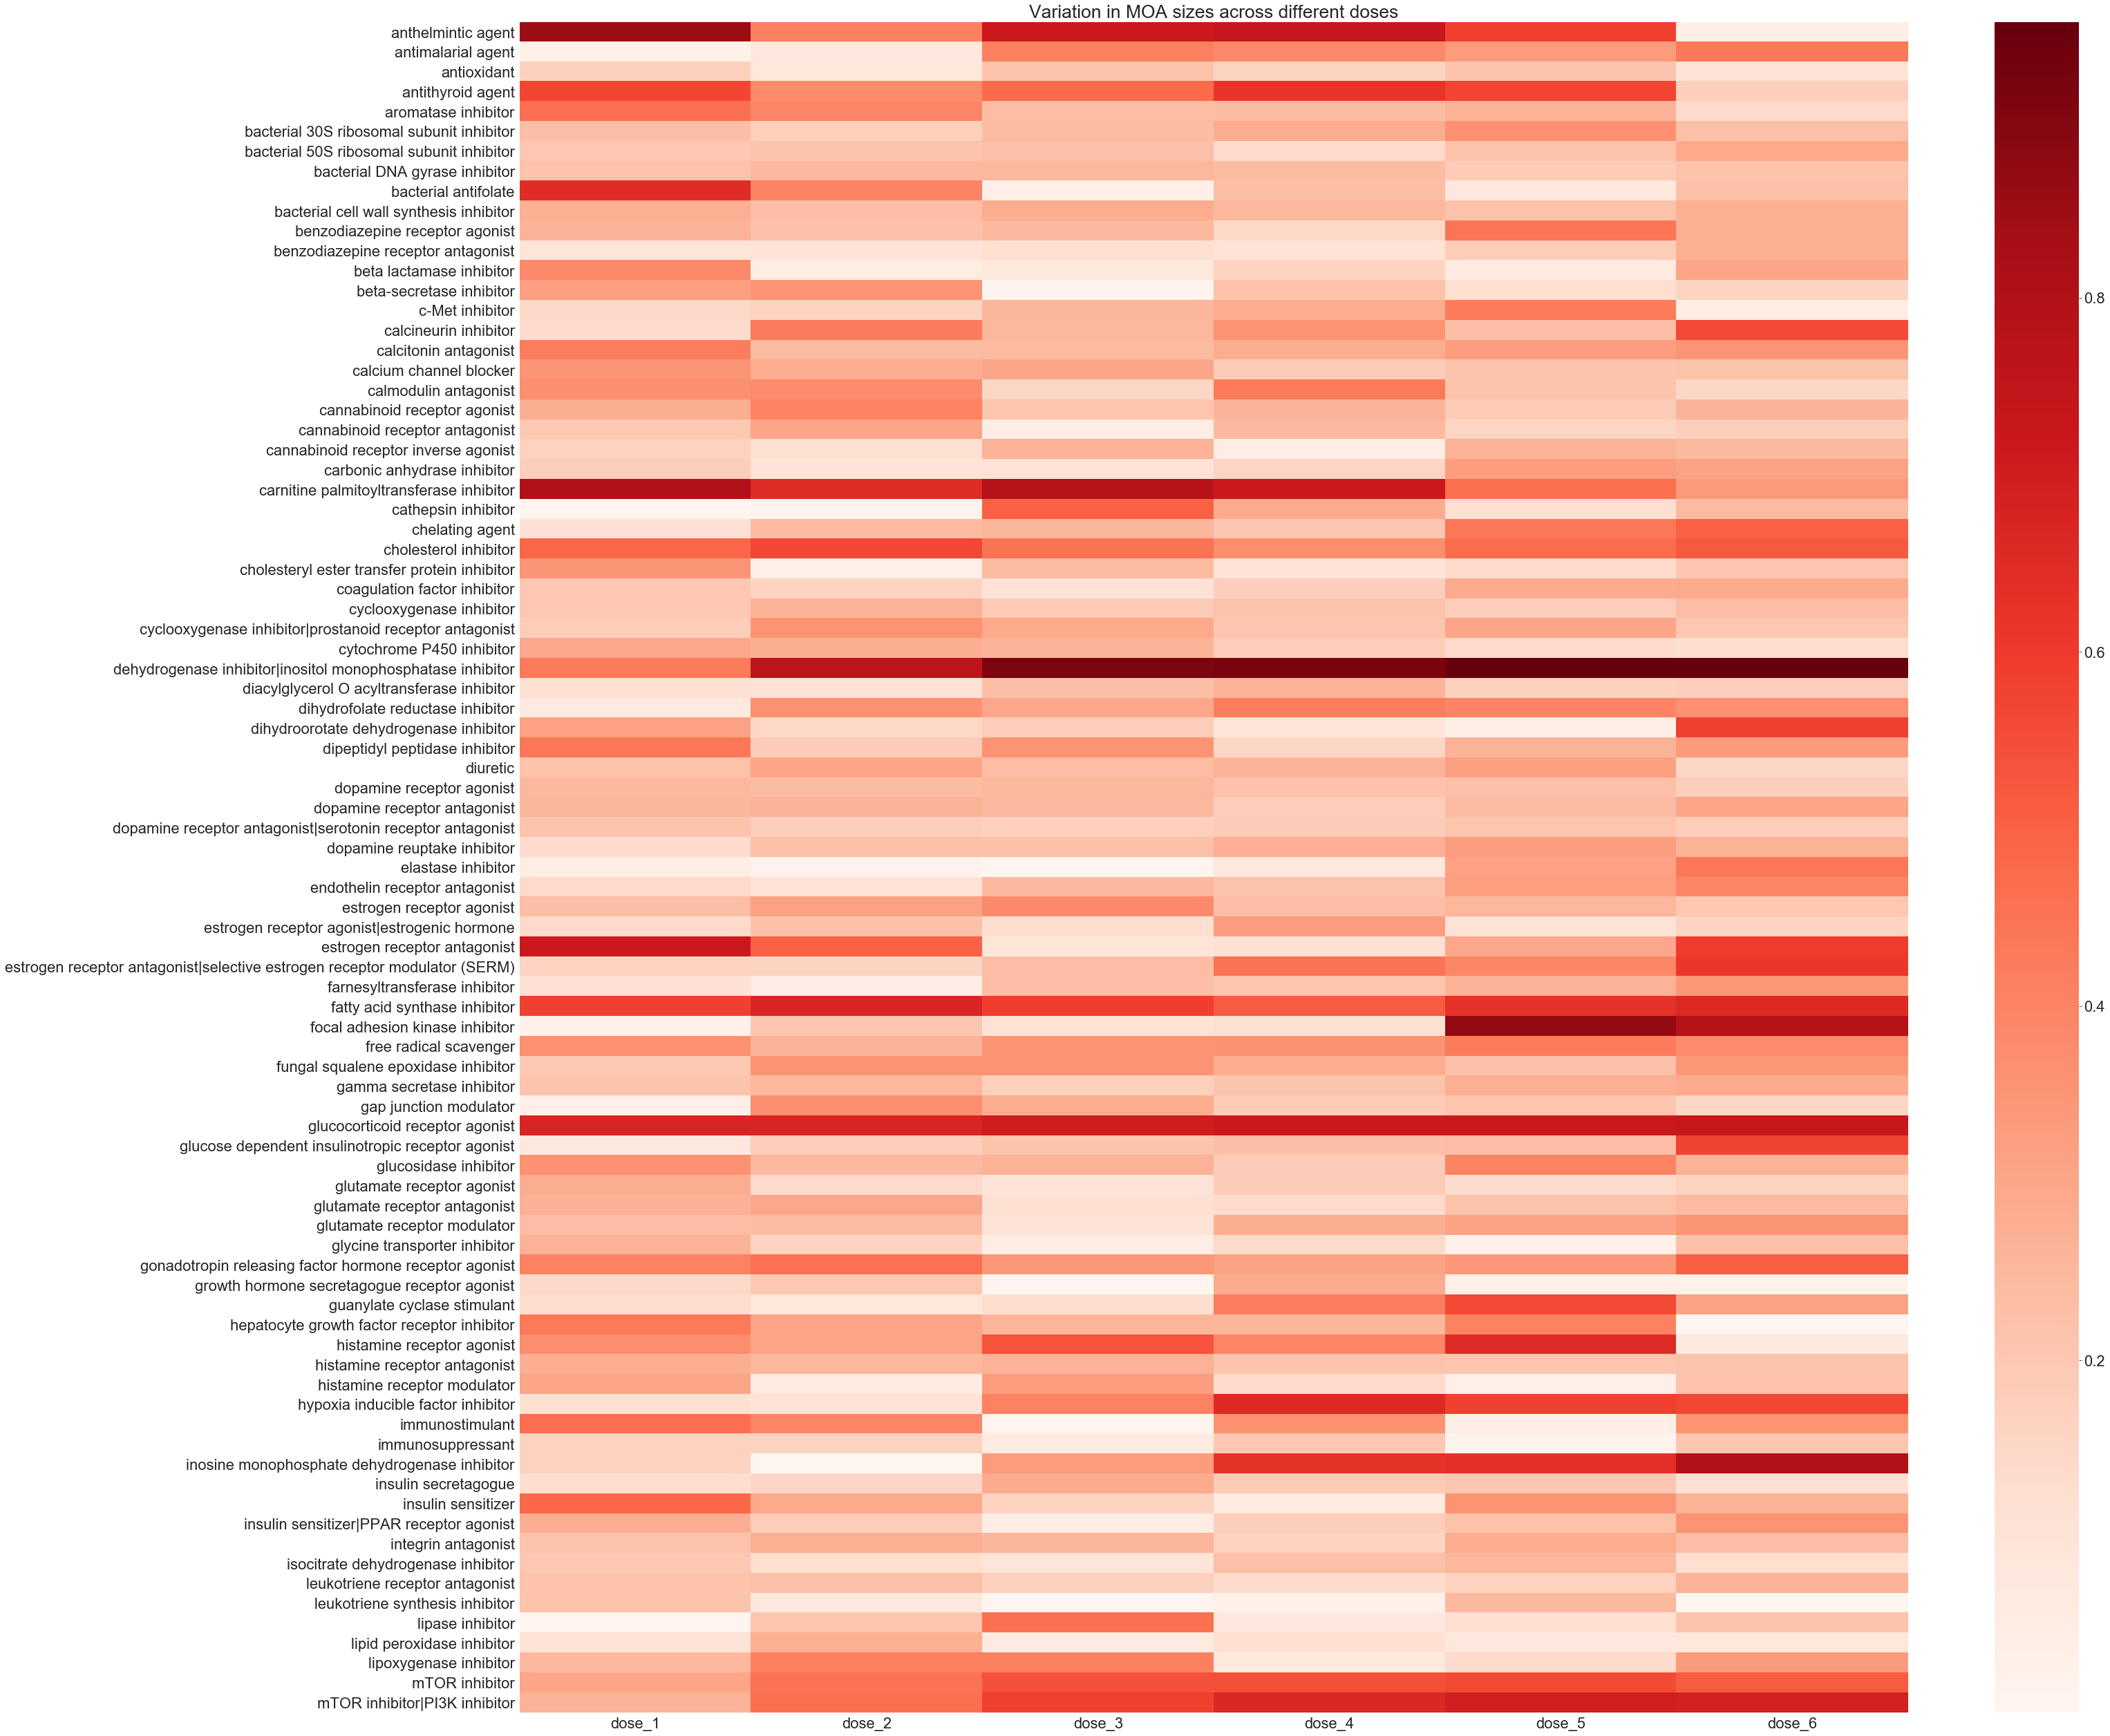

In [32]:
plot_save_heatmap(data_moa_values.iloc[75:160, :], 'modz_dmso_heatmap_2.png')

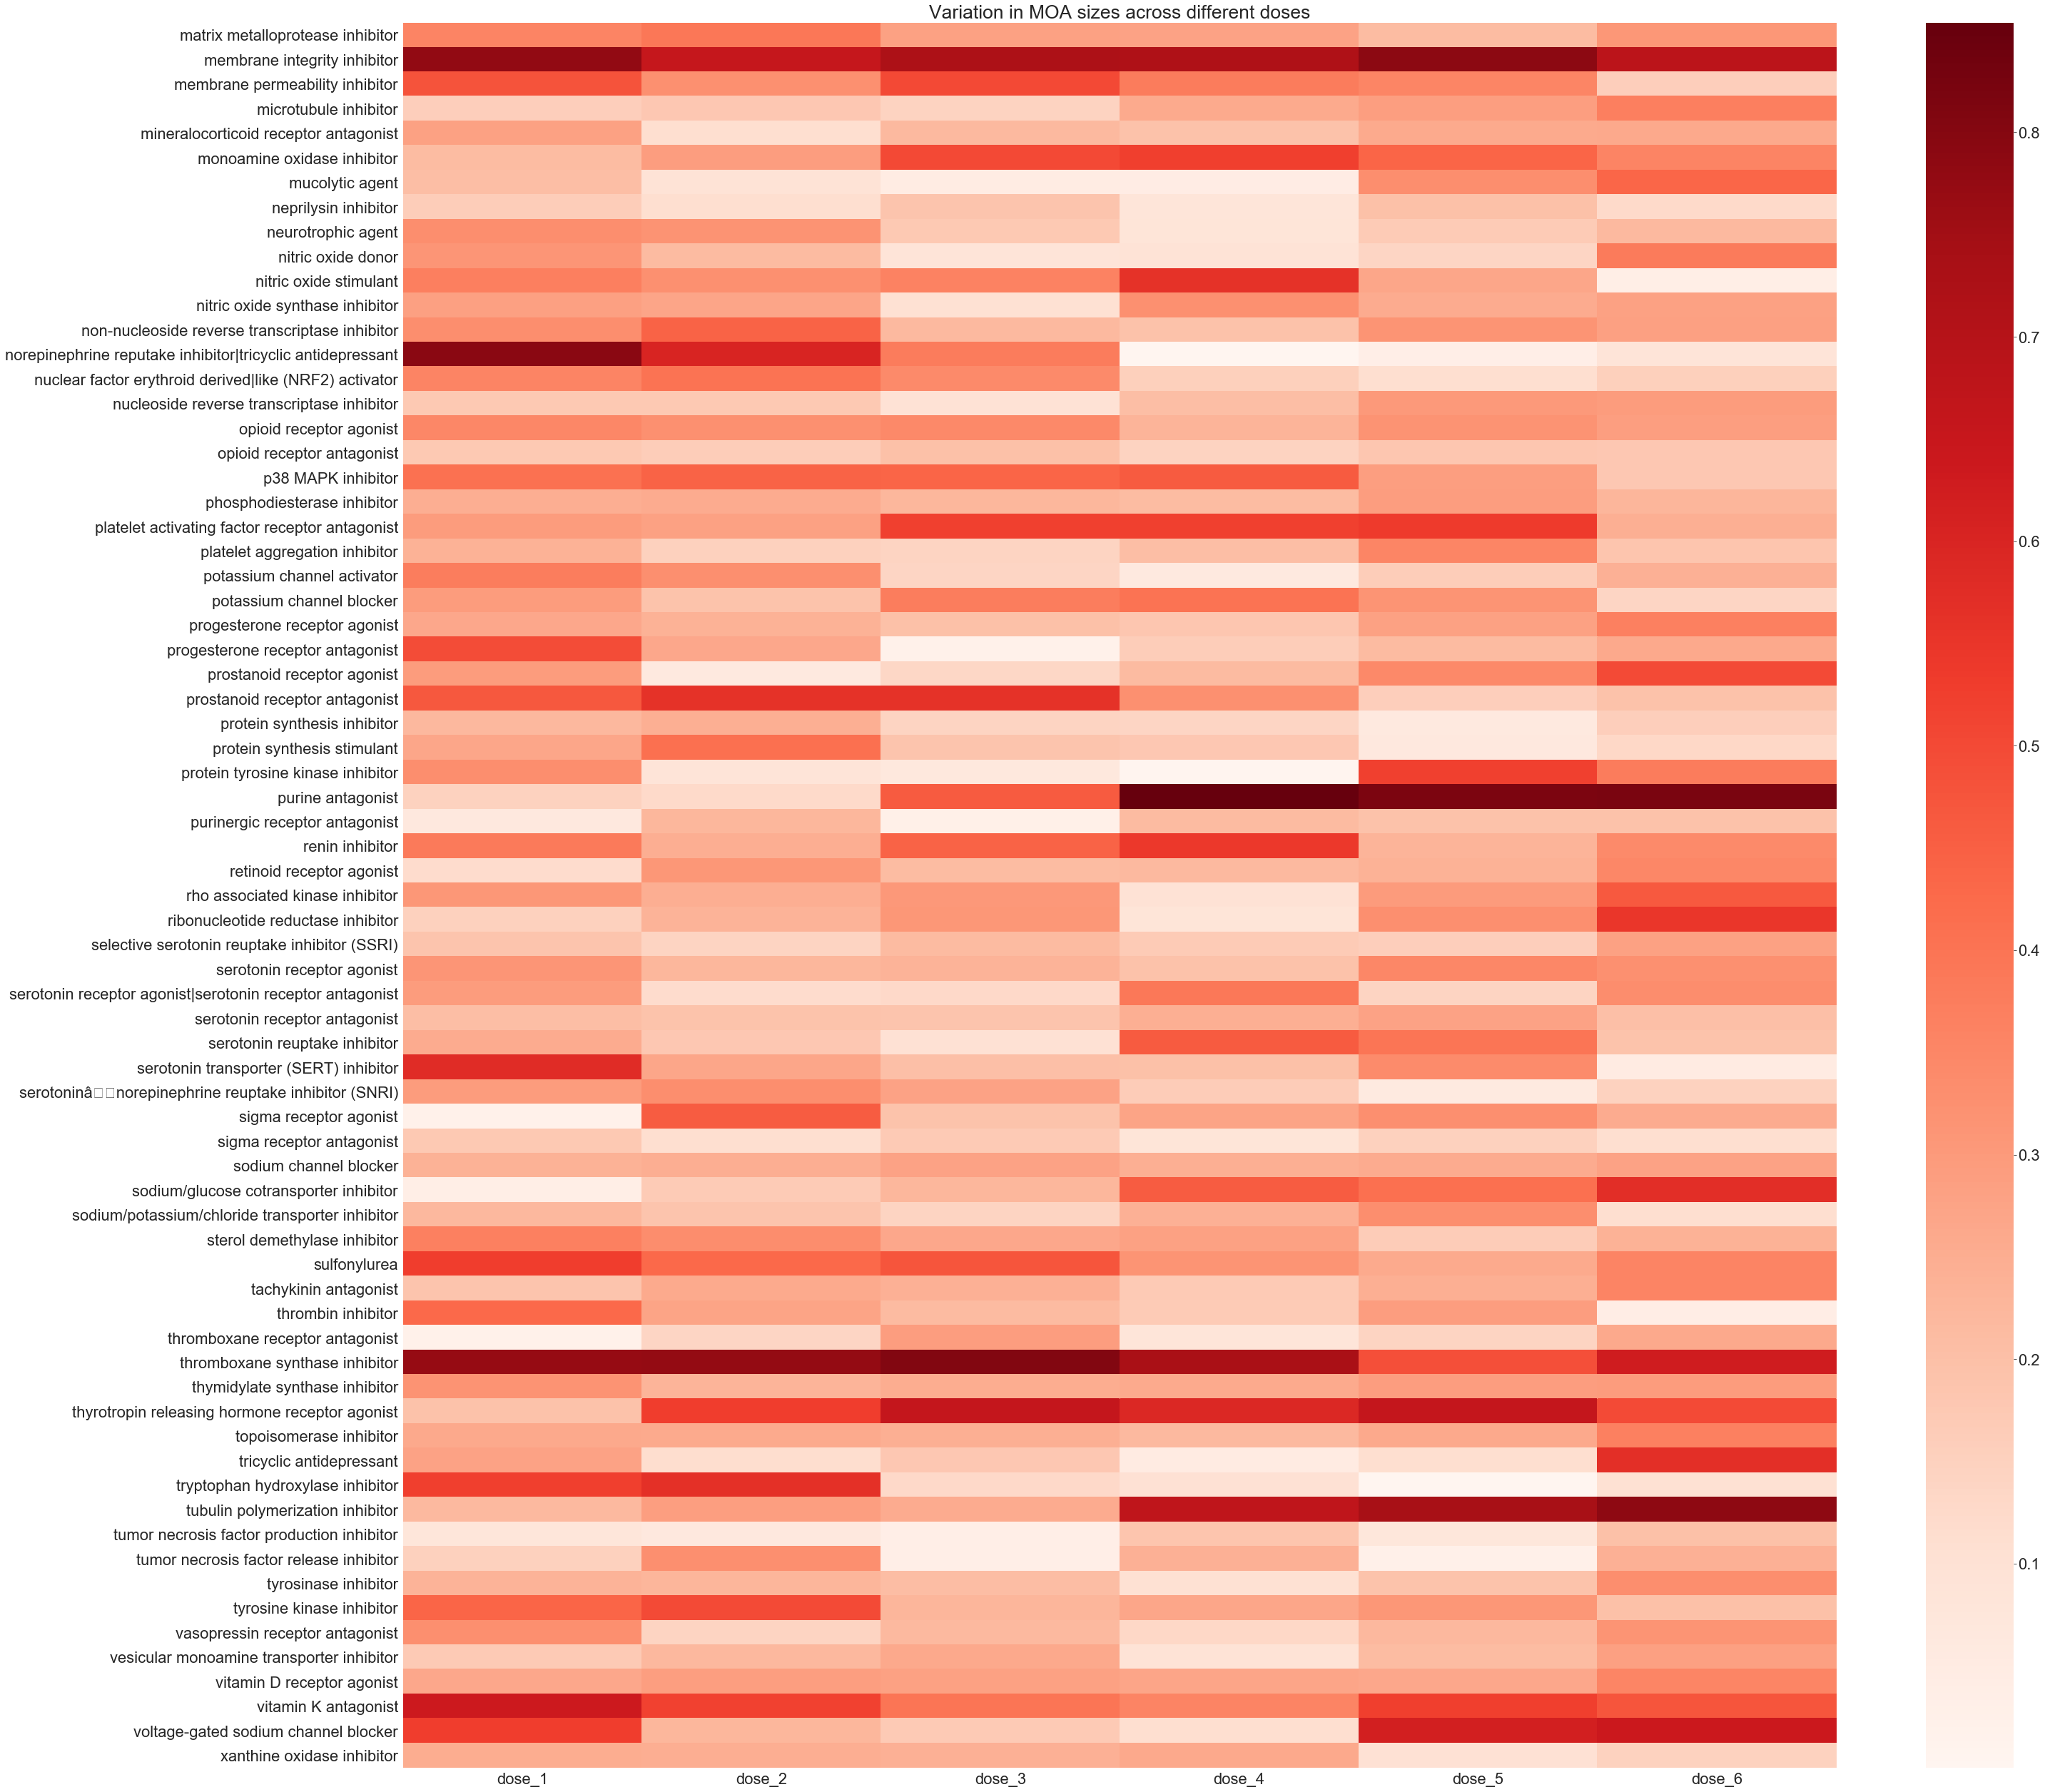

In [33]:
plot_save_heatmap(data_moa_values.iloc[160:, :], 'modz_dmso_heatmap_3.png')